Notebook to compute the eigenmode decomposition of 1D diffusion utilizing 
random walk methodology. Used to validate modal markov formulation for calcium
diffusion. Simple 1d diffusion with no reactions.

11 nodes.

author: Margot Wagner
date created: 6/16/22

# Setup

In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib
import matplotlib.pyplot as plt
import math
from typing import Union, Tuple
# import modules for random walk and eignen implementations
import sys
sys.path.insert(0, '../../src/')
import RandomWalk as rw
import EigenmarkovDiffusion as emd

### Disable Scrolling Cells

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext blackcellmagic

## Notation
(from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

Variable | Description
:--------|:-----------
     $N$ | total number of particles
     $i$ | spatial node index
     $k$ | eigenmode index
   $p_i$ | probability of finding a particle at spatial node $i$
 $v_{ik}$| eigenvector value for the $i$th node and $k$th mode
    $n_i$| the number of particles at node $i$; $$n_i = \sum_k m_k \text{v}_{i k}$$
    $m_k$| the number of particles in eigenmode $k$; $$m_k = \sum_i n_i \text{v}_{i k}$$
    $p_i$| probability of finding a particle in spatial node $i$; normalized number of particles at node $i$; $$p_i = \frac{n_i}{N} = \frac{1}{N} \sum_k m_k \text{v}_{i k}$$
    $q_k$| probability of finding a particle in eigenmode $k$; normalized number of particles in eigenmode $k$; $$q_k = \frac{m_k}{N} =  \sum_i n_i \text{v}_{i k}$$

## Simulation Constants

In [4]:
n_particles = 50  # number of molecules

# MESH
n_spatial_locs = 11  # define number of grid points along 1D line
particle_start_loc = 5

# SIMULATION
n_time_pts = 1000  # number of time points
dt = 1  # time step (usec)
line_length = 4  # total length of diffusion line (um)
diffusion_constant_D = 2.20e-4  # Calcium diffusion coeff (um^2/usec)

# 1D Random Walk Diffusion Simulation
Implementation similar to GeeksforGeeks' [Random Walk (Implementation in Python)](https://www.geeksforgeeks.org/random-walk-implementation-python/).

<div>

</div>

## Init a Random Walk Object

In [5]:
random_walk = rw.RandomWalk(
    n_particles=n_particles,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

## Run Simulation

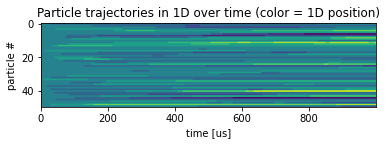

In [6]:
# Get each particle's location over time
particle_locs = random_walk.run_simulation()

# Visualize the output array
plt.imshow(particle_locs, aspect=5)
plt.ylabel('particle #')
plt.xlabel('time [us]')
plt.title('Particle trajectories in 1D over time (color = 1D position)')
plt.show()

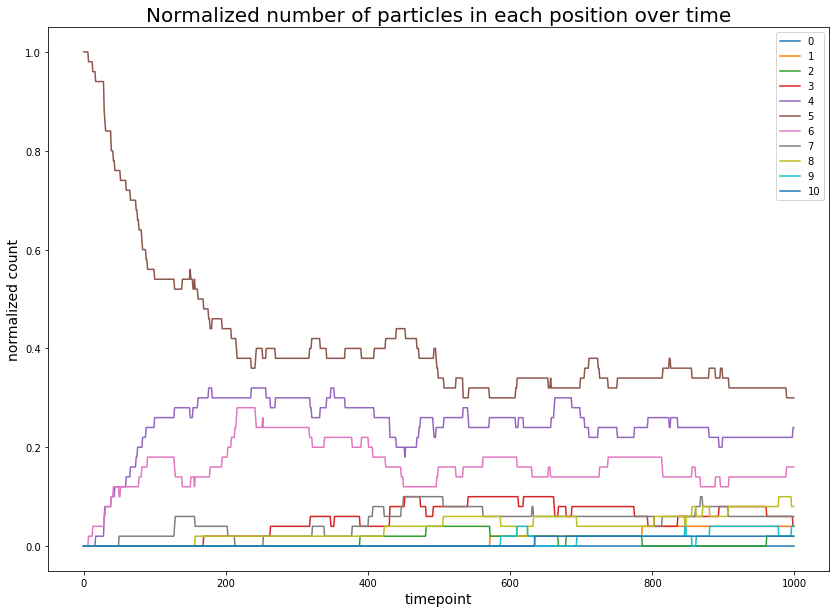

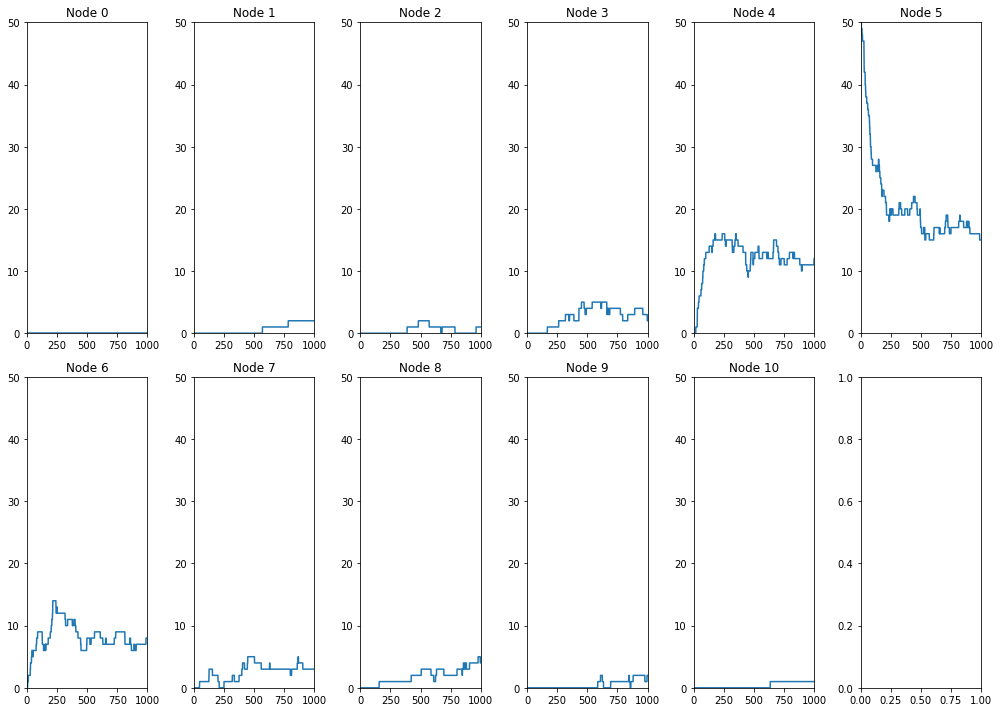

In [7]:
# Reformat the output to instead collect how no. of particles at each location varies (as particles jump around)
unnorm_n_per_loc, n_per_loc, mean_n_per_loc = random_walk.postprocess_run(
    particle_locs=particle_locs,
    plot=True,
    plot_unnorm=True,
)

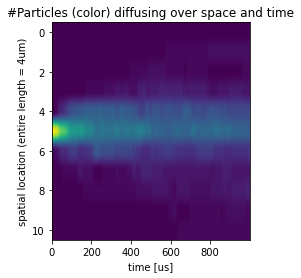

In [8]:
# Also look at the unnormalized output:
plt.imshow(unnorm_n_per_loc, aspect=100)
plt.xlabel('time [us]')
plt.ylabel('spatial location (entire length = {}um)'.format(line_length))
plt.title('#Particles (color) diffusing over space and time')
plt.show()

## Probability of jumping left/right

Rate constant: $k = \frac{D}{dx^2}$

$P(jumping) = kdt$

<div>
<img src="attachment:get_jump_probability.svg" width="500"/>
</div>

In [9]:
# find probability of moving one step
jump_probability, jump_rate_constant_k = random_walk.get_jump_probability()

print('P(jump) = {}\nk(rate) = {}/us'.format(jump_probability, jump_rate_constant_k))
# Note: for dt = 1 (us), these are equal!

P(jump) = 0.00166375
k(rate) = 0.00166375/us


## Variance in jumps
https://mathworld.wolfram.com/RandomWalk1-Dimensional.html

$p_l:$ probability of taking a step to the left ($p$ in the article)

$p_r:$ probability of taking a step to the right ($q$)

$p_0:$ probability of remaining in place (not used in the article)

$n_l:$ number of steps taken to the left ($n_2$)

$n_r:$ number of steps taken to the right ($n_1$)

$N_T:$ number of time steps ($N$ is the number of steps in the article)

Now, sum of the probabilities would be 1:

$p_l + p_r + \color{red}{p_0} = 1$

And the total number of steps taken is:

$n_l + n_r + \color{red}{n_0} = \color{red}{N_T}$

Now let's formulate the probability of a particle moving left, right, or remaining in the same location as a multinomial distribution. So we have:

$N_T$ trials, with three possible outcomes:
- step to the left (occurs $n_l$ times)
- step to the right (occurs $n_r$ times)
- remain in the same location (occurs $n_0$ times)

The probability of taking these steps becomes, using the [multinomial formula](https://en.wikipedia.org/wiki/Multinomial_distribution):

$ P = \frac{\displaystyle N_T!}{\displaystyle n_l! n_r! n_0!} p_r^{n_r} p_l^{n_l} p_0^{n_0} $

(Note: this can be thought of as a permutation problem. Say we have $N_T$ blanks that can be filled with 'L', 'R', or '0', then all possible arrangements of these blanks, using the multiplication rule, is $N_T!$, but we divide out duplicate arrangements since $n_l$, $n_r$, and $n_0$ labels are identical.)

The variance is:
$\text{Var}(left) = N_T p_l (1-p_l) = \text{Var}(right)$, if $p_l = p_r$

In [10]:
random_walk.get_variance() # this probably needs to be fixed

0.00013840320312500002

Using then multimonimal variance formula instead:

In [11]:
jump_var = n_time_pts * jump_probability * (1-jump_probability)
jump_var

1.6609819359375002

And, now for the number of left / right jumps we can expect (the expectation):

In [12]:
## This is the expected number of times a particle jumps to the left (right) over n_time_pts:
jump_exp = n_time_pts * jump_probability
jump_exp

1.66375

So we expect a particle to jump left (right) $1.663 \pm \sqrt{1.661}$ times, over 1000 time steps.

## How often do they jump in simulation?
Looking at trajectories...

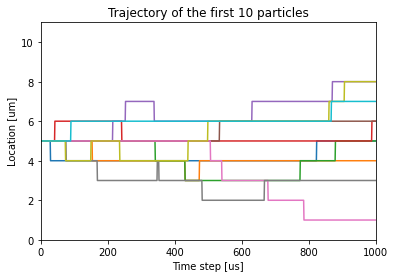

In [13]:
particles_to_plot = 10
plt.plot(particle_locs[:particles_to_plot].T)
plt.xlabel('Time step [us]')
plt.ylabel('Location [um]')
plt.title(f'Trajectory of the first {particles_to_plot} particles')
plt.ylim([0, n_spatial_locs])
plt.xlim([0, n_time_pts])
plt.show()

Each particle's trajectory just represents a sampling from the multinomial distribution.
So we can expect the mean and variance calculated above to match the mean/variance of simulated jumps for the 50 particles here.

In [14]:
num_left_jumps = []
num_right_jumps = []

for particle in range(n_particles):
    locs = particle_locs[particle]
    jumps = np.diff(locs)
    num_left_jumps.append(sum(jumps == -1))
    num_right_jumps.append(sum(jumps == 1))

print('Left Jumps')
print(f'Mean: {np.mean(num_left_jumps)}, Var: {np.var(num_left_jumps)}')
print(num_left_jumps)
print('-'*50)
print('Right Jumps')
print(f'Mean: {np.mean(num_right_jumps)}, Var: {np.var(num_right_jumps)}')
print(num_right_jumps)

Left Jumps
Mean: 1.42, Var: 1.2836
[1, 2, 2, 1, 1, 0, 4, 4, 2, 0, 1, 3, 1, 1, 0, 1, 1, 3, 1, 1, 2, 3, 1, 2, 1, 3, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 2, 0, 4, 1, 1, 4, 0, 2]
--------------------------------------------------
Right Jumps
Mean: 1.66, Var: 2.2243999999999997
[1, 1, 2, 2, 4, 1, 0, 2, 5, 2, 0, 7, 3, 2, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 4, 0, 1, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0, 1, 3, 5, 0, 2, 3, 0, 0, 1, 2, 4, 1]


Would the match between simulated and calculated variance improve given a bigger number of particles?

(Adding more particles here should be equivalent to re-running a sim with fewer particles over and over)

In [15]:
n_particles_big = 10000 # 1000

# Could take ~10s to run
random_walk_big = rw.RandomWalk(
    n_particles=n_particles_big,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

particle_locs_big = random_walk_big.run_simulation()

jumps = np.diff(particle_locs_big, axis=1) # +1 and -1 would represent jumps
num_left_jumps = np.sum(jumps == -1, axis=1)
num_right_jumps = np.sum(jumps == 1, axis=1)

print('Left Jumps')
print(f'Mean: {np.mean(num_left_jumps)}, Var: {np.var(num_left_jumps)}')
#print(num_left_jumps)
print('-'*50)
print('Right Jumps')
print(f'Mean: {np.mean(num_right_jumps)}, Var: {np.var(num_right_jumps)}')
#print(num_right_jumps)

Left Jumps
Mean: 1.6434, Var: 1.6162364399999998
--------------------------------------------------
Right Jumps
Mean: 1.6299, Var: 1.61172599


Back to the 50 particle case...

Lets add some variance bounds to the plot:

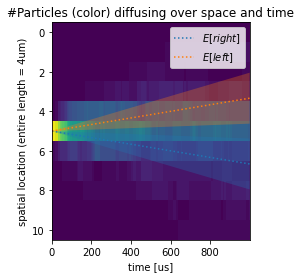

In [16]:
# Plot the expected jumps
plt.plot([0, n_time_pts], 
         [particle_start_loc, particle_start_loc + jump_exp],
         ':',
         label = '$E[right]$'
        )# + np.sqrt(jump_var)])
plt.plot([0, n_time_pts], 
         [particle_start_loc, particle_start_loc - jump_exp],
         ':',
         label = '$E[left]$'
        ) # - np.sqrt(jump_var)])

# Plot the variance in this expectation
plt.fill_between([0, n_time_pts], 
         [particle_start_loc, particle_start_loc + jump_exp + np.sqrt(jump_var)],
         [particle_start_loc, particle_start_loc + jump_exp - np.sqrt(jump_var)],
         alpha=0.3,
        )# ])
plt.fill_between([0, n_time_pts], 
         [particle_start_loc, particle_start_loc - jump_exp + np.sqrt(jump_var)],
         [particle_start_loc, particle_start_loc - jump_exp - np.sqrt(jump_var)],
         alpha=0.3,
        )# ])

# Plot the simulated results
plt.imshow(unnorm_n_per_loc, aspect=100, interpolation='none')
plt.xlabel('time [us]')
plt.ylabel('spatial location (entire length = {}um)'.format(line_length))
plt.title('#Particles (color) diffusing over space and time')
plt.legend()
plt.show()

This doesn't make sense...we want the spread in the diffusion itself, instead we are looking at the likelihood that a particle jumped either left or right. That is, above, we are plotting only the positive (negative) diffs in the particle's location, and the variance in that.

But what we actually need is the spread (variance) of the particle's trajectory, which can be thought of as a time series, where every next step is sampled from the multinomial distribution:

Time | ith particle's step | ith particle's position
:-- |:-- | :--
0 | 0  | 5
1 | -1 | 4
2 | 0  | 4
3 | -1 | 3
4 | +1 | 4
5 | 0  | 4
6 | 0  | 4
... | ...
999 | 0 | 5

Given that the particle could have jumped either left or right with equal probability, its expected final position should be...its starting location.

And the spread (variance) should be the sum of the variances of either jump.

How do we write this out?

Consider the random variables:
- $X_0:$ number of times the particle didn't move in the $n=1000$ time steps.
- $X_l:$ number of times (out of $n$) the particle jumped left.
- $X_r:$ number of times (out of $n$) the particle jumped right.

The particles final position should be:

$start - X_l + X_r$

The expected final position:

$E[start - X_l + X_r] = E[start] - E[X_l] + E[X_r] = start$

And the variance would be:

$var[start - X_l + X_r] = var[start] + var[X_l] + var[X_r] = 2 var[jump]$

Finally, six times this variance should explain most of the diffusion's spreading:


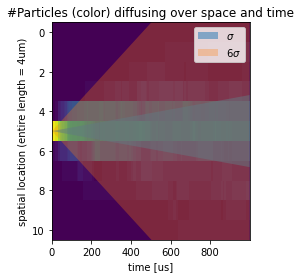

In [17]:
sigma = np.sqrt(2*jump_var)

plt.fill_between([0, n_time_pts],
                 [particle_start_loc, particle_start_loc + sigma],
                 [particle_start_loc, particle_start_loc - sigma],
                 label='$\sigma$',
                 alpha=0.5,
                )# ])

plt.fill_between([0, n_time_pts], 
                 [particle_start_loc, particle_start_loc + 6*sigma],
                 [particle_start_loc, particle_start_loc - 6*sigma],
                 label = '$6\sigma$',
                 alpha=0.3,
                )# ])

# Plot the simulated results
plt.imshow(unnorm_n_per_loc, aspect=100, interpolation='none')
plt.xlabel('time [us]')
plt.ylabel('spatial location (entire length = {}um)'.format(line_length))
plt.title('#Particles (color) diffusing over space and time')
plt.legend()
plt.show()

### Revisit variance from the notes

TO DO: Look into the posterior probabilities from the notes:
$p(1-p)$

## Eigenmode Markov Model

In [18]:
scaling_factor = 2 # for modes to nodes (or back?)

emd_model = emd.EigenmarkovDiffusion(
    n_particles=n_particles,
    n_spatial_locs=n_spatial_locs,
    n_time_pts=n_time_pts,
    particle_start_loc=particle_start_loc,
    scaling_factor = scaling_factor,
    # optional params below:
    dt=dt,
    line_length=line_length,
    diffusion_constant_D=diffusion_constant_D,
)

### Jump Probability

In [19]:
# find probability of moving one step
kdt, k = emd_model.get_jump_probability()
print('P(jump) = {}\nk(rate) = {}/us'.format(kdt, k))
# Note: for dt = 1 (us), these are equal!

P(jump) = 0.00166375
k(rate) = 0.00166375/us


### Transition Matrix
<div>
<img src="attachment:transition_rate.svg" width="500"/>
</div>

This uses the rate constant  $k$ as defined above:

$$k = \frac{D}{dx^2}$$

where $D$ is the diffusion constant, and $dx$ is the distance between spatial nodes.

This leads us to the transition matrix $A$:

$$ A = \begin{bmatrix} 
  k &  -k &   0 &   0 &  0 & \ldots &   0 \\
 -k &  2k &  -k &   0 &  0 & \ldots &   0 \\
  0 &  -k &  2k &  -k &  0 & \ldots &   0 \\
  0 &   0 &  -k &  2k & -k & \ldots &   0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
  0 &   0 &   0 &   0 &  k &     2k &  -k \\
  0 &   0 &   0 &   0 &  0 &     -k &   k \\
\end{bmatrix}
$$

array([[ 0.00166375, -0.00166375,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.00166375,  0.0033275 , -0.00166375,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.00166375,  0.0033275 , -0.00166375,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.00166375,  0.0033275 , -0.00166375,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.00166375,  0.0033275 ,
        -0.00166375,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.00166375,
         0.0033275 , -0.00166375,  0.        ,  0.        ,  0.        ,
         0.   

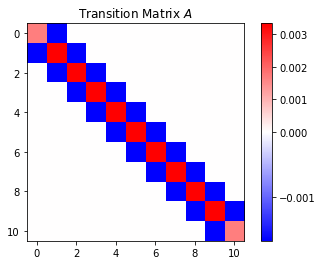

In [20]:
A = emd_model.get_transition_matrix()

# Use a diverging colormap
## https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging
cmap = matplotlib.cm.bwr

# Center the colormap on 0
## https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
divnorm = matplotlib.colors.TwoSlopeNorm(vcenter=0) #, vmin=-.01, vmax=.01)

plt.imshow(A, cmap=cmap, norm=divnorm)

plt.title("Transition Matrix $A$")
plt.colorbar()
A

## Eigenvectors, Eigenvalues, and Eigenmodes

EIGENVALUES
 0     1     2     3     4     5     6     7     8     9     10     
[0.    0.    0.001 0.001 0.002 0.003 0.004 0.005 0.006 0.006 0.007]

EIGENVECTORS
   0    1    2    3    4    5    6    7    8    9    10    
[[ 1.  -1.4 -1.4 -1.3 -1.2 -1.1  0.9 -0.8  0.6  0.4  0.2]
 [ 1.  -1.3 -0.9 -0.4  0.2  0.8 -1.2  1.4 -1.4 -1.1 -0.6]
 [ 1.  -1.1 -0.2  0.8  1.4  1.3 -0.6 -0.4  1.2  1.4  0.9]
 [ 1.  -0.8  0.6  1.4  0.9 -0.4  1.4 -1.1 -0.2 -1.3 -1.2]
 [ 1.  -0.4  1.2  1.1 -0.6 -1.4  0.2  1.3 -0.9  0.8  1.4]
 [ 1.  -0.   1.4  0.  -1.4 -0.  -1.4  0.   1.4 -0.  -1.4]
 [ 1.   0.4  1.2 -1.1 -0.6  1.4  0.2 -1.3 -0.9 -0.8  1.4]
 [ 1.   0.8  0.6 -1.4  0.9  0.4  1.4  1.1 -0.2  1.3 -1.2]
 [ 1.   1.1 -0.2 -0.8  1.4 -1.3 -0.6  0.4  1.2 -1.4  0.9]
 [ 1.   1.3 -0.9  0.4  0.2 -0.8 -1.2 -1.4 -1.4  1.1 -0.6]
 [ 1.   1.4 -1.4  1.3 -1.2  1.1  0.9  0.8  0.6 -0.4  0.2]]

EIGENMODES (e^(-eigenvalue * t))


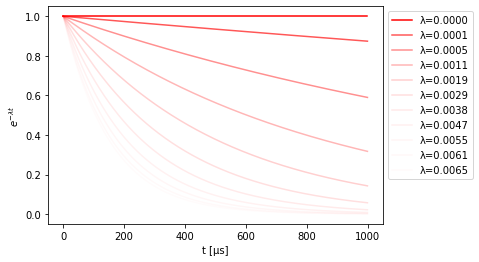

EIGENVECTORS (over space)


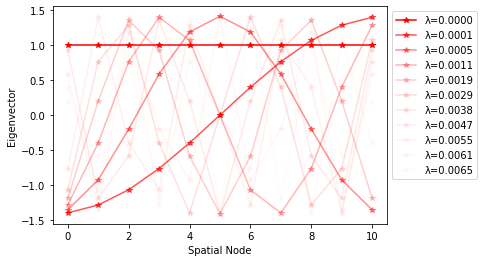

In [21]:
eigenvalues, eigenvectors, eval_sort_index = emd_model.get_eigenvalues_and_vectors(
    print_output=True, 
    plot_eigenmodes=True,
    plot_eigenvectors=True
)

## Eigenmode Impulse Injection Initial Conditions

(Copy/pasting from [stochastic-eme-soln.tex](https://www.overleaf.com/project/60ae85bacdfc625489517928))

If the simulation is an impulse of $N$ particles at node $x$, then the number of particles at each spatial node is zero, except for the location of the impulse injection 

### PARTICLE COUNTS

\begin{equation}
\begin{split}
    %m_{\pm k} = \frac{1}{2} \left(1 \pm \frac{\sum_i n_i \text{v}_{i k}}{\sqrt{N\sum_i n_i (\text{v}_{i k})^2}} \right) \\ % MER: Normalized version
    m_{\pm k} = \frac{1}{2} \left(\sqrt{N\sum_i n_i (\text{v}_{i k})^2} \pm \sum_i n_i \text{v}_{i k} \right) \\
    = \frac{1}{2} \left(\sqrt{N n_x (\text{v}_{x k})^2} \pm n_x \text{v}_{x k} \right) \\ 
    = \frac{1}{2} \left(\sqrt{N^2 (\text{v}_{x k})^2} \pm N \text{v}_{x k} \right)
\end{split}
\end{equation}

EIGENMODE INITIAL CONDITIONS
POSITIVE
[50.          0.         70.71067812  0.          0.          0.
  0.          0.         70.71067812  0.          0.        ]
NEGATIVE
[ 0.          0.          0.          0.         70.71067812  0.
 70.71067812  0.          0.          0.         70.71067812]



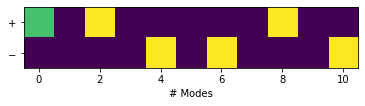

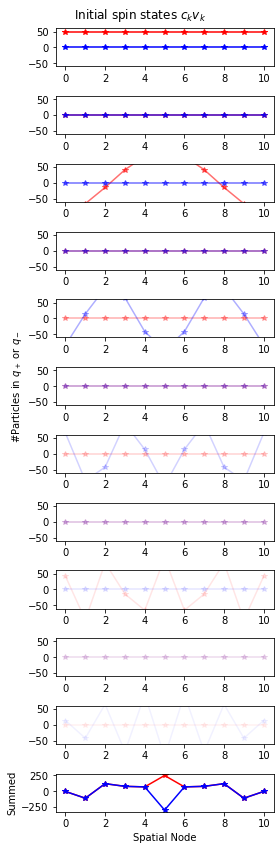

In [22]:
# Find initial values for the number of particles in each eigenmode
# For n_particles = 1, it should just be 1 and 0 respectively
init_n_positive_modes, init_n_negative_modes = emd_model.get_eme_init_conditions(
    print_output=True, 
    plot_output=True
)

### Transition Probability In Modal Space

Transition probability given by 

\begin{equation} 
    P(transition_{\pm k \rightarrow \mp k}) = \frac{\lambda}{2} dt 
\end{equation}

where $\lambda$ is the eigenVALUE (not eigenvector or eigenmode)

In [23]:
# initialize eigenmode Markov model transition probabilities
eigenmode_transition_probability = emd_model.get_eigenmode_transition_probability(
    print_output=True
)

EIGENMODE TRANSITION PROBABILITIES
0	1	2	3	4	5	6	7	8	9	10	
0.0e+00 6.7e-05 2.6e-04 5.7e-04 9.7e-04 1.4e-03 1.9e-03 2.4e-03 2.8e-03 3.1e-03 3.3e-03 


## Run Markov Simulation

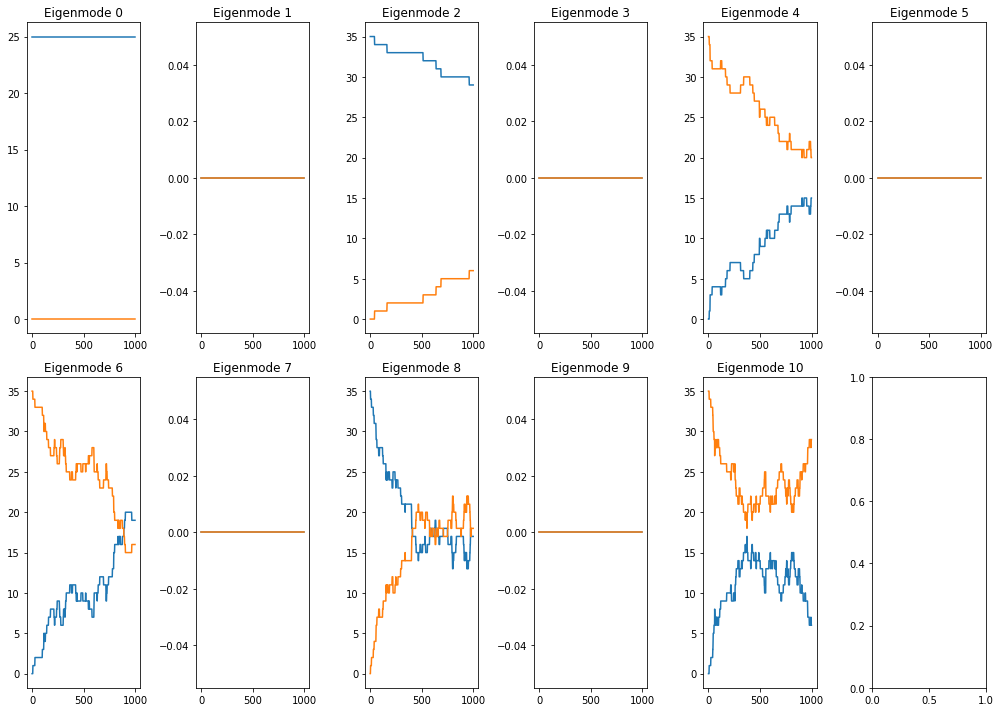

In [24]:
# run Markov model
n_per_eigenmode_state = emd_model.run_simulation(
    plot_simulation=True,
)

## Inverse Transform

To transform the <u>number</u> of particles in each eigenmode to the <u>number</u> at each spatial location, we use the following equation:

\begin{equation} 
\begin{split}
    n_i = \sum_k \text{v}_{ik} m_k \\
    = \sum_k \text{v}_{ik} \left( m_{+k} - m_{-k} \right)
\end{split}
\end{equation}





In [25]:
# inverse transform; convert eigenmode representation to node representation
node_vals_from_modes = emd_model.convert_to_spatial_nodes(
    n_per_eigenmode_state,
    print_output=True
)

NORMALIZED COUNT PER SPATIAL NODE (FROM EIGENMODES) (N_NODES x TIME)
PRINTING SIMULATION TIME POINTS SEPARATED BY 100 TIME POINTS
0	[ 0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.]
1	[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
2	[ 0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.]
3	[ 0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1]
4	[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
5	[0.5 0.4 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1]
6	[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
7	[ 0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1]
8	[ 0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.]
9	[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
10	[ 0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.]



In [26]:
def graph_num_comparison(
    n1: np.ndarray, 
    n2: np.ndarray, 
    legend_vals=[], 
    title="",
    normalize=True,
    n_particles = 50, 
    particle_start_loc = 5
    ):
    
    """Graph comparing normalized number of particles at each node 
    and in each mode.

    Args:
        n1: normalized number of particles in one condition 
        (particles per time)
        n2: normalized number of particles in one condition 
        (particles per time)
    """
    import math
    # make subplots
    half_n_nodes = math.ceil(n1.shape[0] / 2)
    fig, axes = plt.subplots(half_n_nodes, 2, figsize=(14, 10))
    
    # normalize number of particles
    if normalize:
        n1 = n1 / n_particles
        n2 = n2 / n_particles

    
    for i, ax in enumerate(axes.flat):
        if i == n_spatial_locs:
            break
        ax.plot(list(range(n_time_pts)), n1[i, :])
        ax.plot(list(range(n_time_pts)), n2[i, :])
        ax.legend(legend_vals)
        ax.axhline(y=0, color='black', linestyle='--')
        ax.set_title("{} {}".format(title, i))

    fig.tight_layout()
    plt.show()
    
    print("{} PARTICLES STARTED NODE {}".format(n_particles, particle_start_loc))
    print("NORMALIZATION TURNED ON? \t", normalize)

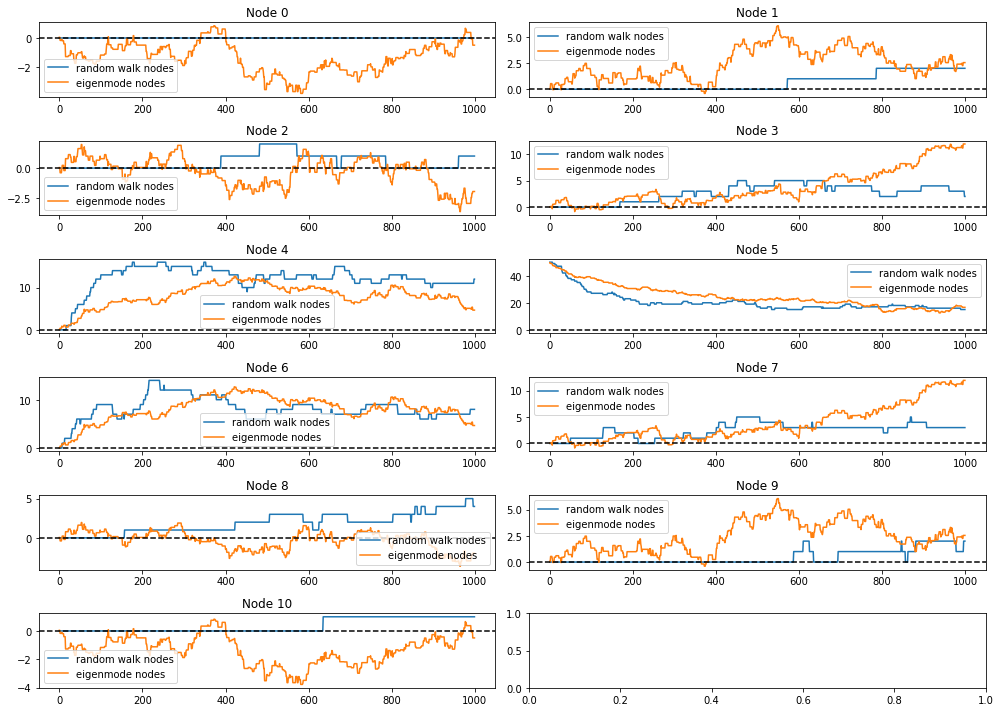

50 PARTICLES STARTED NODE 5
NORMALIZATION TURNED ON? 	 False


In [27]:
# compare with random walk simulation
graph_num_comparison(
    unnorm_n_per_loc, 
    node_vals_from_modes,
    legend_vals=["random walk nodes", "eigenmode nodes"], 
    title="Node",
    n_particles = n_particles,
    particle_start_loc = particle_start_loc,
    normalize = False,
)